In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 불러오기

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Category 데이터 encoding
## Encoding과정에서 eptiope과 antigen정보를 사용하지 않는다.

In [3]:
def get_dic(data):
    vocab = {}
    for name in data:
        if name not in vocab:
            vocab[name]=0
        vocab[name] += 1
    vocab_sorted = sorted(vocab.items(), key=lambda x:x[1], reverse=True)
    token_dic = {}
    i = 1
    token_dic['Unknown'] = 0
    for (name, freq) in vocab_sorted:
        token_dic[name] = i
        i += 1
    return token_dic

def dic_except(dic, a):
    try:
        return dic[a]
    except:
        return dic['Unknown']

dic_assay_method_technique = get_dic(train['assay_method_technique'])
dic_assay_group = get_dic(train['assay_group'])
dic_disease_type = get_dic(train['disease_type'])
dic_disease_state = get_dic(train['disease_state'])

In [4]:
def get_preprocessing(data_type, df, dic_assay_method_technique = dic_assay_method_technique, dic_assay_group = dic_assay_group, dic_disease_type = dic_disease_type, dic_disease_state = dic_disease_state):
    
    df = df.drop(columns = ['reference_date', 'reference_journal', 'reference_title', 'reference_IRI', 
                             'antigen_code', 'id', 'start_position', 'end_position'])

    
    df['assay_method_technique'] = df['assay_method_technique'].map(lambda a: dic_except(dic_assay_method_technique, a))
    df['assay_group'] = df['assay_group'].map(lambda a: dic_except(dic_assay_group, a))
    df['disease_type'] = df['disease_type'].map(lambda a: dic_except(dic_disease_type, a))
    df['disease_state'] = df['disease_state'].map(lambda a: dic_except(dic_disease_state, a))
    
    if data_type != 'test':
        X = df.drop(columns = ['epitope_seq', 'antigen_seq', 'label', 'qualitative_label'])
    else:
        X = df.drop(columns = ['epitope_seq', 'antigen_seq'])
    
    y = None
    if data_type != 'test':
        y = df['label']
    print(f'{data_type} dataframe preprocessing was done.')
    return X, np.array(y)

# Data split

In [5]:
X, y = get_preprocessing('train', train)

X_test, y_test = get_preprocessing('test', test)

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=12)

train dataframe preprocessing was done.
test dataframe preprocessing was done.


## Null인 부분 normalized 된 값으로 채워주기

In [6]:
def get_card_split(df, cols, n=11):
    """
    Splits categorical columns into 2 lists based on cardinality (i.e # of unique values)
    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame from which the cardinality of the columns is calculated.
    cols : list-like
        Categorical columns to list
    n : int, optional (default=11)
        The value of 'n' will be used to split columns.
    Returns
    -------
    card_low : list-like
        Columns with cardinality < n
    card_high : list-like
        Columns with cardinality >= n
    """
    cond = df[cols].nunique() > n
    card_high = cols[cond]
    card_low = cols[~cond]
    return card_low, card_high

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

categorical_transformer_low = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoding", OneHotEncoder(handle_unknown="ignore", sparse=False)),
    ]
)

categorical_transformer_high = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        # 'OrdianlEncoder' Raise a ValueError when encounters an unknown value. Check https://github.com/scikit-learn/scikit-learn/pull/13423
        ("encoding", OrdinalEncoder()),
    ]
)

numeric_features = X_train.select_dtypes(include=[np.number]).columns ## X_train에 대해 normalize
categorical_features = X_train.select_dtypes(include=["object"]).columns ## X_train에 대해 normalize

categorical_low, categorical_high = get_card_split(
    X_train, categorical_features
)
## X_train에 대해 normalize

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical_low", categorical_transformer_low, categorical_low),
        ("categorical_high", categorical_transformer_high, categorical_high),
    ]
)

pre = preprocessor

X_train = pre.fit_transform(X_train)  # X_train에 대해서 학습

X_val = pre.transform(X_val)
X_test = pre.transform(X_test)

# Train and Validation Result

In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

def cal_mat(preds, labels):
    result = {}
    result['acc'] = accuracy_score(labels, preds)
    result['AUC'] = roc_auc_score(labels, preds)
    result['f1'] = f1_score(labels, preds, average='macro')
    result['precision'] = precision_score(labels, preds)
    result['recall'] = recall_score(labels, preds)
    result['bal_acc'] = balanced_accuracy_score(labels, preds)
    
    return result

clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)

preds = clf.predict(X_val)
cal_mat(preds, y_val)

{'acc': 0.9701543379713334,
 'AUC': 0.8601009878596009,
 'f1': 0.8995660713110597,
 'precision': 0.9304476507584166,
 'recall': 0.7256203115983844,
 'bal_acc': 0.8601009878596009}

### 대회의도와 다르게 Epitope, Antigen과 관련된 feature를 사용하지 않아도 성능이 좋게 나오게 되어버렸다.

# Random Forest의 feature importance를 확인해 보면 number_of_responses와 number_of_tested가 classification에 중요한 영향을 미치는 것을 확인

Feature ranking:
1. feature number_of_responses (0.514)
2. feature disease_state (0.182)
3. feature number_of_tested (0.104)
4. feature assay_method_technique (0.089)
5. feature disease_type (0.087)
6. feature assay_group (0.024)


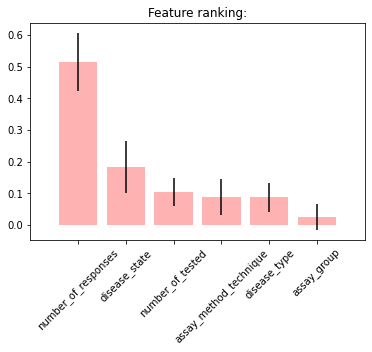

In [8]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, X.columns[indices][f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature ranking:")
plt.bar(range(X.shape[1]), importances[indices],
        color='r', yerr=std[indices], align='center', alpha=0.3)
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()